# Predikce vítěze a přidání rozšíření o část modelu

In [1]:
# Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.metrics import confusion_matrix, classification_report

import joblib

try:
    # Import shap, lime
    import shap
    import lime
    import lime.lime_tabular
except ImportError as e:
    print(e)
    print("You need to install the missing modules using pip (e.g., 'pip install shap lime xgboost')")

In [2]:
df = pd.read_csv('merge_data_ultimate.csv', sep=';')

df.columns
#Nejprve seřadíme data podle jezdce a závodu (důležité pro rolling)
df = df.sort_values(by=['driverId', 'raceId'])

#Rolling součet bodů jezdce za posledních 5 závodů
df['rolling_driver_points_last_5'] = (
  df.groupby('driverId')['points_in_previous_race']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).sum())
)

#Relativní forma - poměr k max v závodě
df['driver_form_ratio'] = (
    df['rolling_driver_points_last_5'] /
    df.groupby('raceId')['rolling_driver_points_last_5'].transform('max')
)

#Rozdíl oproti průměru v závodě
df['driver_vs_avg'] = (
    df['rolling_driver_points_last_5'] -
    df.groupby('raceId')['rolling_driver_points_last_5'].transform('mean')
)



# --- Kontrola ---
print("\nFeature engineering hotov.")
print(df[[
    'year', 'raceId', 'driverId',
    'rolling_driver_points_last_5', 'driver_form_ratio', 'driver_vs_avg'
]].sort_values(by='rolling_driver_points_last_5', ascending=False).head(10))

df.to_csv('model_data_ultimate.csv', index=False)


Feature engineering hotov.
     year  raceId  driverId  rolling_driver_points_last_5  driver_form_ratio  \
102  2024       6       830                         127.0                1.0   
122  2024       7       830                         126.0                1.0   
142  2024       8       830                         126.0                1.0   
162  2024       9       830                         125.0                1.0   
202  2024      11       830                         125.0                1.0   
182  2024      10       830                         125.0                1.0   
222  2024      12       830                         110.0                1.0   
242  2024      13       830                         103.0                1.0   
82   2024       5       830                         102.0                1.0   
462  2024      24       830                          99.0                1.0   

     driver_vs_avg  
102         100.20  
122         100.15  
142          99.35  
162    

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 7 to 476
Data columns (total 82 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                480 non-null    int64  
 1   age                                 480 non-null    int64  
 2   years_in_f1                         480 non-null    int64  
 3   races_with_each_team_since_1995     480 non-null    int64  
 4   F2_champion                         480 non-null    int64  
 5   Former_F1_World_Champion            480 non-null    int64  
 6   home_race                           480 non-null    int64  
 7   driverId                            480 non-null    int64  
 8   raceId                              480 non-null    int64  
 9   laps_in_previous_race               80 non-null     float64
 10  driver_points_at_stage_of_season    480 non-null    float64
 11  race_Abu Dhabi Grand Prix           480 non-null  

In [5]:
drivers = pd.read_csv('datasets/drivers.csv')
constructors = pd.read_csv('datasets/constructors.csv')


In [6]:
# Vytvořit plné jméno jezdce
drivers['driver_name'] = drivers['forename'] + ' ' + drivers['surname']

# Merge jezdců
df = df.merge(drivers[['driverId', 'driver_name']], on='driverId', how='left')

# Merge týmů
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')

# Přejmenovat 'name' na 'team_name'
df = df.rename(columns={'name': 'team_name'})

In [7]:
import joblib

model = joblib.load('random_forest_grid_search.pkl')
#model = joblib.load('grid_search_rf.best_estimator_')



In [8]:
rf_model = model.best_estimator_
print(rf_model)

Pipeline(steps=[('scl', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=42))])


In [9]:
print(rf_model.named_steps)

{'scl': StandardScaler(), 'clf': RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)}


In [10]:
# Najdi všechny sloupce typu object
object_cols = df.select_dtypes(include='object').columns

# Převod PRAVDA/NEPRAVDA na True/False
for col in object_cols:
    if df[col].isin(['PRAVDA', 'NEPRAVDA']).all():
        df[col] = df[col].map({'PRAVDA': 1, 'NEPRAVDA': 0})

In [11]:
# 4. Oprava názvů sloupců
rename_map = {
    'circuit_type_Permanent Race Track': 'Circuit_Type_Permanent_Race_Track',
    'circuit_type_Street Circuit': 'Circuit_Type_Street_Circuit',
    # Přidáš další podle potřeby
}

df = df.rename(columns=rename_map)

In [12]:
#Proměnné, které očekává model
model_feature_names = model.best_estimator_.named_steps['scl'].feature_names_in_
print(model_feature_names)

['year' 'F2_champion' 'Former_F1_World_Champion' 'home_race'
 'starting_grid_position' 'points_in_previous_race'
 'fastest_lap_from_last_race' 'laps_in_previous_race'
 'driver_points_at_stage_of_season' 'age' 'years_in_f1'
 'races_with_each_team_since_1995' 'Number_Of_Stops' 'Total_time_in_pits'
 'Avg_time_in_pits' 'Weather_Conditions_Dry' 'Weather_Conditions_Rain'
 'Circuit_Type_Permanent_Race_Track ' 'Circuit_Type_Street_Circuit '
 'rolling_driver_points_last_5' 'driver_form_ratio' 'driver_vs_avg'
 'race_Argentine Grand Prix' 'race_Australian Grand Prix'
 'race_Austrian Grand Prix' 'race_Azerbaijan Grand Prix'
 'race_Bahrain Grand Prix' 'race_Belgian Grand Prix'
 'race_Brazilian Grand Prix' 'race_British Grand Prix'
 'race_Canadian Grand Prix' 'race_Chinese Grand Prix'
 'race_Emilia Romagna Grand Prix' 'race_European Grand Prix'
 'race_French Grand Prix' 'race_German Grand Prix'
 'race_Hungarian Grand Prix' 'race_Indian Grand Prix'
 'race_Italian Grand Prix' 'race_Japanese Grand Prix

In [13]:
#nové Proměnné
new_data_feature_names = df.columns.values
print(new_data_feature_names)

['year' 'age' 'years_in_f1' 'races_with_each_team_since_1995'
 'F2_champion' 'Former_F1_World_Champion' 'home_race' 'driverId' 'raceId'
 'laps_in_previous_race' 'driver_points_at_stage_of_season'
 'race_Abu Dhabi Grand Prix' 'race_Australian Grand Prix'
 'race_Austrian Grand Prix' 'race_Azerbaijan Grand Prix'
 'race_Bahrain Grand Prix' 'race_Belgian Grand Prix'
 'race_Brazilian Grand Prix' 'race_British Grand Prix'
 'race_Canadian Grand Prix' 'race_Chinese Grand Prix'
 'race_Dutch Grand Prix' 'race_Emilia Romagna Grand Prix'
 'race_Hungarian Grand Prix' 'race_Italian Grand Prix'
 'race_Japanese Grand Prix' 'race_Las Vegas Grand Prix'
 'race_Mexico City Grand Prix' 'race_Miami Grand Prix'
 'race_Monaco Grand Prix' 'race_Qatar Grand Prix'
 'race_Saudi Arabian Grand Prix' 'race_Singapore Grand Prix'
 'race_Spanish Grand Prix' 'race_United States Grand Prix'
 'engine_manufacturer_Ferrari' 'engine_manufacturer_Mercedes'
 'engine_manufacturer_Red Bull' 'engine_manufacturer_Renault'
 'constru

In [14]:
# Uložit jména stranou
driver_and_team = df[['driver_name', 'team_name']].copy()

# Připravit data pro predikci
X_features = df.drop(columns=['driver_name', 'team_name'])

In [15]:
missing_features = set(model_feature_names) - set(X_features.columns)
extra_features = set(X_features.columns) - set(model_feature_names) 
print(missing_features)

print("\n🔍 Chybějící featury (doplníme nulami):", missing_features)
print("\n🔍 Přebytečné featury (odstraníme):", extra_features)

{'constructor_nationality_British', 'Weather_Conditions_Rain', 'constructorId_20', 'constructorId_210', 'constructor_nationality_Swiss', 'constructorId_51', 'constructorId_19', 'race_German Grand Prix', 'Circuit_Type_Street_Circuit ', 'constructorId_208', 'constructorId_21', 'constructorId_164', 'constructorId_207', 'engine_manufacturer_Supertec', 'constructor_nationality_Spanish', 'constructorId_5', 'race_Portuguese Grand Prix', 'constructorId_15', 'engine_manufacturer_Petronas', 'race_Russian Grand Prix', 'constructorId_213', 'constructorId_205', 'constructorId_11', 'race_San Marino Grand Prix', 'constructorId_3', 'constructorId_206', 'constructor_nationality_Austrian', 'constructorId_2', 'constructor_nationality_Indian', 'fastest_lap_from_last_race', 'Circuit_Type_Permanent_Race_Track ', 'constructor_nationality_Irish', 'constructorId_117', 'race_European Grand Prix', 'constructorId_166', 'engine_manufacturer_Mugen-Honda', 'constructorId_17', 'constructorId_6', 'constructorId_9', 'r

In [16]:
df_filtered = df.copy()

In [17]:
for col in missing_features:
    X_features[col] = 0

In [18]:
X_features = X_features[list(model_feature_names)]
df_filtered.head()
X_features.head()

year  F2_champion  Former_F1_World_Champion  home_race  \
0  2024            1                         1          0   
1  2024            1                         1          0   
2  2024            1                         1          0   
3  2024            1                         1          0   
4  2024            1                         1          0   

   starting_grid_position  points_in_previous_race  \
0                     9.0                      6.0   
1                     8.0                      2.0   
2                    11.0                      0.0   
3                     7.0                      2.0   
4                    18.0                      2.0   

   fastest_lap_from_last_race  laps_in_previous_race  \
0                           0                   58.0   
1                           0                   57.0   
2                           0                   50.0   
3                           0                   15.0   
4                           0                    NaN   

   driver_points_at_stage_of_season  age  years_in_f1  \
0                               0.0   39           17   
1                               8.0   39           17   
2                              12.0   39           17   
3                              28.0   39           17   
4                              30.0   39           17   

   races_with_each_team_since_1995  Number_Of_Stops  Total_time_in_pits  \
0                              223              2.0             49181.0   
1                              224              1.0             20170.0   
2                              225              1.0             17596.0   
3                              226              3.0           1627985.0   
4                              227              2.0             45180.0   

   Avg_time_in_pits  Weather_Conditions_Dry  Weather_Conditions_Rain  \
0      24590.500000                       0                        0   
1      20170.000000                       0                        0   
2      17596.000000                       0                        0   
3     542661.666667                       0                        0   
4      22590.000000                       0                        0   

   Circuit_Type_Permanent_Race_Track   Circuit_Type_Street_Circuit   \
0                                   0                             0   
1                                   0                             0   
2                                   0                             0   
3                                   0                             0   
4                                   0                             0   

   rolling_driver_points_last_5  driver_form_ratio  driver_vs_avg  \
0                           NaN                NaN            NaN   
1                           6.0           0.230769           0.90   
2                           8.0           0.156863          -1.90   
3                           8.0           0.103896          -8.30   
4                          10.0           0.098039         -11.35   

   race_Argentine Grand Prix  race_Australian Grand Prix  \
0                          0                           0   
1                          0                           0   
2                          0                           1   
3                          0                           0   
4                          0                           0   

   race_Austrian Grand Prix  race_Azerbaijan Grand Prix  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   race_Bahrain Grand Prix  race_Belgian Grand Prix  \
0                        1                        0   
1                        0                        0   
2                       

In [19]:
# Model předpokládá: binární klasifikace "vyhraje závod / nevyhraje"
y_pred = model.predict(X_features)
y_pred_proba = model.predict_proba(X_features)

# Získání pravděpodobnosti třídy 1 (výhra)
if len(y_pred_proba.shape) == 2 and y_pred_proba.shape[1] == 2:
    probabilities = y_pred_proba[:, 1]
else:
    probabilities = y_pred_proba

# Přiřazení výsledků zpět do dataframe
df_filtered['prediction_probability'] = probabilities
df_filtered['predictions'] = y_pred

In [20]:
y_pred_proba[:,1]

array([0.15      , 0.12      , 0.135     , 0.115     , 0.11      ,
       0.145     , 0.155     , 0.16      , 0.155     , 0.2205    ,
       0.3325    , 0.315     , 0.32      , 0.305     , 0.3       ,
       0.335     , 0.39625   , 0.28525773, 0.085     , 0.14      ,
       0.14      , 0.135     , 0.17525773, 0.1455    , 0.125     ,
       0.14      , 0.1       , 0.155     , 0.17      , 0.105     ,
       0.13      , 0.11      , 0.145     , 0.13      , 0.095     ,
       0.105     , 0.105     , 0.105     , 0.11      , 0.095     ,
       0.135     , 0.115     , 0.115     , 0.095     , 0.105     ,
       0.105     , 0.13      , 0.13      , 0.065     , 0.055     ,
       0.055     , 0.065     , 0.06      , 0.06      , 0.06      ,
       0.025     , 0.05      , 0.07      , 0.075     , 0.075     ,
       0.065     , 0.065     , 0.065     , 0.065     , 0.055     ,
       0.06      , 0.07      , 0.075     , 0.07      , 0.07      ,
       0.07      , 0.07      , 0.08      , 0.18511628, 0.18083

In [21]:
results = pd.DataFrame({
    'driver_name': driver_and_team['driver_name'],
    'team_name': driver_and_team['team_name'],
    'prediction': y_pred,
    'prediction_probability': probabilities
})
print(results)

        driver_name team_name  prediction  prediction_probability
0    Lewis Hamilton  Mercedes           0                   0.150
1    Lewis Hamilton  Mercedes           0                   0.120
2    Lewis Hamilton  Mercedes           0                   0.135
3    Lewis Hamilton  Mercedes           0                   0.115
4    Lewis Hamilton  Mercedes           0                   0.110
..              ...       ...         ...                     ...
475  Logan Sargeant  Williams           0                   0.090
476  Logan Sargeant  Williams           0                   0.110
477  Logan Sargeant  Williams           0                   0.095
478  Logan Sargeant  Williams           0                   0.095
479  Logan Sargeant  Williams           0                   0.095

[480 rows x 4 columns]


In [22]:
# --- VÝBĚR VÍTĚZŮ NA KAŽDÝ ZÁVOD ---
winners_list = []

# Najdeme všechny sloupce typu 'race_'
race_columns = [col for col in df_filtered.columns if col.startswith('race_')]

for race_col in race_columns:
    # Vyber závodníky, kteří se účastní daného závodu (máš tam 1/0)
    racers_in_race = df_filtered[df_filtered[race_col] == 1]

    if not racers_in_race.empty:
        # Najdi jezdce s nejvyšší prediction_probability
        winner = racers_in_race.loc[racers_in_race['prediction_probability'].idxmax()]
        
        winners_list.append({
            'race': race_col.replace('race_', '').replace('_', ' ').title(),  # Krásnější název závodu
            'driver': winner['driver_name'] if 'driver_name' in winner else 'Unknown',
            'Team': winner['team_name'] if 'team_name' in winner else 'Unknown',
            'Prediction Probability': winner['prediction_probability']
        })

# Převedení seznamu na DataFrame
winners_df = pd.DataFrame(winners_list)

# Seřazení podle názvu závodu (nepovinné)
winners_df = winners_df.sort_values('race').reset_index(drop=True)

# Uložení výsledků
winners_df.to_csv('predicted_winners_per_race.csv', index=False)

print("\n Výběr vítězů hotov!")
print(winners_df.head(25))



 Výběr vítězů hotov!
                         race          driver      Team  \
0        Abu Dhabi Grand Prix  Max Verstappen  Red Bull   
1       Australian Grand Prix  Max Verstappen  Red Bull   
2         Austrian Grand Prix  Max Verstappen  Red Bull   
3       Azerbaijan Grand Prix  Lewis Hamilton  Mercedes   
4          Bahrain Grand Prix  Max Verstappen  Red Bull   
5          Belgian Grand Prix  Max Verstappen  Red Bull   
6        Brazilian Grand Prix    Lando Norris   McLaren   
7          British Grand Prix  Max Verstappen  Red Bull   
8         Canadian Grand Prix  Max Verstappen  Red Bull   
9          Chinese Grand Prix  Max Verstappen  Red Bull   
10           Dutch Grand Prix  Max Verstappen  Red Bull   
11  Emilia Romagna Grand Prix  Max Verstappen  Red Bull   
12       Hungarian Grand Prix  Max Verstappen  Red Bull   
13         Italian Grand Prix    Lando Norris   McLaren   
14        Japanese Grand Prix  Max Verstappen  Red Bull   
15       Las Vegas Grand Prix  Max

In [23]:
import pandas as pd

# Najdeme sloupce závodů (např. race_melbourne, race_jeddah atd.)
race_columns = [col for col in df_filtered.columns if col.startswith('race_')]

top3_per_race = []

for race_col in race_columns:
    race_name = race_col.replace('race_', '').replace('_', ' ').title()
    racers_in_race = df_filtered[df_filtered[race_col] == 1]

    if not racers_in_race.empty:
        sorted_racers = racers_in_race.sort_values(by='prediction_probability', ascending=False)
        top3_drivers = list(sorted_racers['driver_name'].head(3))
        top3_per_race.append({'race': race_name, 'predicted_top3': top3_drivers})

top3_df = pd.DataFrame(top3_per_race)
top3_df.to_csv('predicted_top3_per_race.csv', index=False)

print(" predicted_top3_per_race.csv uložen.")


 predicted_top3_per_race.csv uložen.


In [24]:
y_true= pd.read_csv('y_true.csv', sep=';')
y_true.head()
predictions = pd.read_csv('predicted_winners_per_race.csv')

print(predictions.columns)
print(y_true.columns)

Index(['race', 'driver', 'Team', 'Prediction Probability'], dtype='object')
Index(['race', 'driver'], dtype='object')


In [25]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Načtení predikcí
predicted_df = pd.read_csv("predicted_top3_per_race.csv")
predicted_df['predicted_top3'] = predicted_df['predicted_top3'].apply(ast.literal_eval)  # převod string → list
actual_df = pd.read_csv("y_true.csv", sep=';')
# Načtení skutečných výsledků
if actual_df.shape[1] == 1:
    actual_df.columns = ['race_driver']
    actual_df[['race', 'true_driver']] = actual_df['race_driver'].str.split(';', expand=True)
else:
    actual_df.columns = ['race', 'true_driver']
actual_df['race'] = actual_df['race'].str.strip()
actual_df['true_driver'] = actual_df['true_driver'].str.strip()
actual_df = actual_df[['race', 'true_driver']]



# Sloučení predikcí a reality
merged_df = pd.merge(predicted_df, actual_df, on='race', how='inner')

# Výpočet reciprocal rank
def compute_rr(row):
    try:
        rank = row['predicted_top3'].index(row['true_driver']) + 1
        return 1 / rank
    except ValueError:
        return 0

merged_df['reciprocal_rank'] = merged_df.apply(compute_rr, axis=1)
mrr_score = merged_df['reciprocal_rank'].mean()

# Winner accuracy – správný jezdec na 1. místě
merged_df['winner_correct'] = merged_df['predicted_top3'].apply(lambda x: x[0]) == merged_df['true_driver']
winner_accuracy = merged_df['winner_correct'].mean()

merged_df['in_top3'] = merged_df.apply(
    lambda x: x['true_driver'] in x['predicted_top3'], axis=1
)
top3_precision = merged_df['in_top3'].mean()

# === 4. Výpis ===
print(merged_df[['race', 'true_driver', 'predicted_top3', 'reciprocal_rank', 'winner_correct', 'in_top3']])
print(f"\n Mean Reciprocal Rank (MRR): {mrr_score:.3f}")
print(f" Winner Accuracy: {winner_accuracy:.2%}")
print(f" Top-3 Precision: {top3_precision:.2%}")


                         race      true_driver  \
0        Abu Dhabi Grand Prix     Lando Norris   
1       Australian Grand Prix     Carlos Sainz   
2         Austrian Grand Prix   George Russell   
3       Azerbaijan Grand Prix    Oscar Piastri   
4          Bahrain Grand Prix   Max Verstappen   
5          Belgian Grand Prix   Lewis Hamilton   
6        Brazilian Grand Prix   Max Verstappen   
7          British Grand Prix   Lewis Hamilton   
8         Canadian Grand Prix   Max Verstappen   
9          Chinese Grand Prix   Max Verstappen   
10           Dutch Grand Prix     Lando Norris   
11  Emilia Romagna Grand Prix   Max Verstappen   
12       Hungarian Grand Prix    Oscar Piastri   
13         Italian Grand Prix  Charles Leclerc   
14        Japanese Grand Prix   Max Verstappen   
15       Las Vegas Grand Prix   George Russell   
16     Mexico City Grand Prix     Carlos Sainz   
17           Miami Grand Prix     Lando Norris   
18          Monaco Grand Prix  Charles Leclerc   


In [26]:
merged_df.to_csv("mrr_detailed_results.csv", index=False)


In [27]:
# Výpočet základních metrik
total_races = len(merged_df)
correct_first_place = (merged_df['reciprocal_rank'] == 1.0).sum()
in_top3 = (merged_df['reciprocal_rank'] > 0).sum()

# Přesnost vítěze na 1. místě
winner_accuracy = correct_first_place / total_races

# Pokrytí – kolikrát byl vítěz alespoň v top 3
top3_coverage = in_top3 / total_races

# Průměrné umístění vítěze (když je v top 3)
mean_rank_if_hit = merged_df[merged_df['reciprocal_rank'] > 0]['reciprocal_rank'].apply(lambda x: 1/x).mean()

# Výpis
print(f"\n Další metriky:")
print(f" Winner Accuracy (vítěz na 1. místě): {winner_accuracy:.2%}")
print(f" Top-3 Coverage (vítěz v top 3): {top3_coverage:.2%}")
print(f" Mean Rank (když byl vítěz v top 3): {mean_rank_if_hit:.2f}")



 Další metriky:
 Winner Accuracy (vítěz na 1. místě): 33.33%
 Top-3 Coverage (vítěz v top 3): 70.83%
 Mean Rank (když byl vítěz v top 3): 1.76


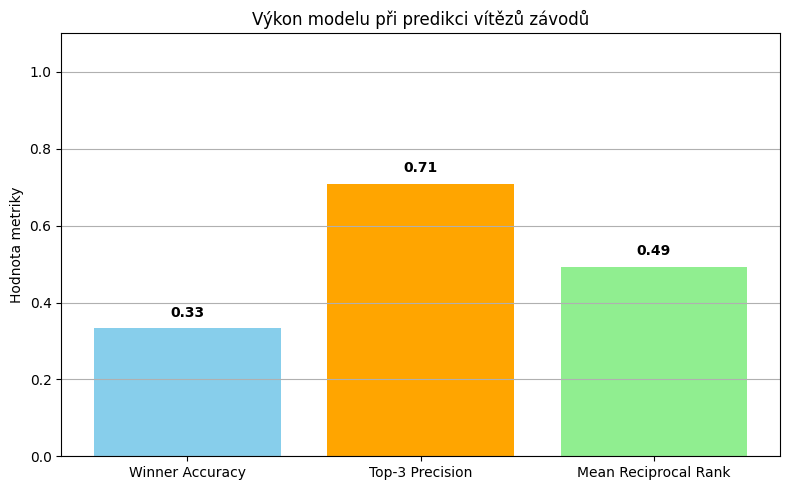

In [28]:
# ===  Vizuální porovnání metrik ===
metrics = {
    'Winner Accuracy': winner_accuracy,
    'Top-3 Precision': top3_precision,
    'Mean Reciprocal Rank': mrr_score
}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'lightgreen'])
plt.ylim(0, 1.1)
plt.title('Výkon modelu při predikci vítězů závodů')
plt.ylabel('Hodnota metriky')
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('mrr_metriky_vysledky.png', dpi=300)
plt.show()


In [29]:
merged_df['true_driver_position'] = merged_df.apply(
    lambda row: row['predicted_top3'].index(row['true_driver']) + 1 if row['true_driver'] in row['predicted_top3'] else None,
    axis=1
)

hits_df = merged_df[merged_df['true_driver_position'].notnull()]
mean_position = hits_df['true_driver_position'].mean()
mean_position_error = (hits_df['true_driver_position'] - 1).mean()

print(f"\n Průměrná pozice vítěze (když byl v top 3): {mean_position:.2f}")
print(f" Průměrná odchylka pozice od ideálu (1. místo): {mean_position_error:.2f}")



 Průměrná pozice vítěze (když byl v top 3): 1.76
 Průměrná odchylka pozice od ideálu (1. místo): 0.76


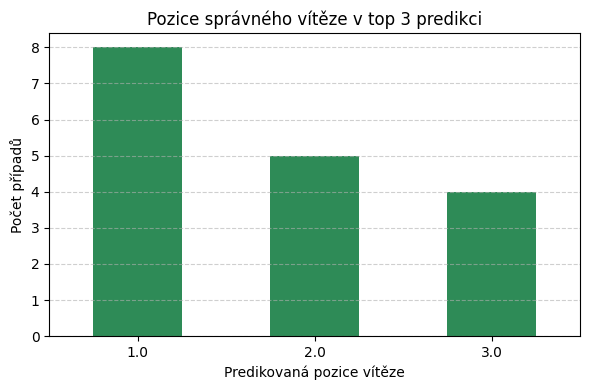

In [30]:
import matplotlib.pyplot as plt

# Spočítáme, kolikrát byl vítěz predikován na dané pozici
position_counts = hits_df['true_driver_position'].value_counts().sort_index()

# Vykreslení
plt.figure(figsize=(6, 4))
position_counts.plot(kind='bar', color='seagreen')
plt.title('Pozice správného vítěze v top 3 predikci')
plt.xlabel('Predikovaná pozice vítěze')
plt.ylabel('Počet případů')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('pozice_viteze_top3.png', dpi=300)
plt.show()

In [31]:
std_dev = hits_df['true_driver_position'].std()
print(f" Směrodatná odchylka pozice vítěze: {std_dev:.2f}")

 Směrodatná odchylka pozice vítěze: 0.83


In [32]:
race_columns = [col for col in df_filtered.columns if col.startswith('race_')]

# Definice bodovaciho systemu F1
points_system = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}


In [33]:
#  Vytvoreni listu pro vysledky
race_results = []

for race_col in race_columns:
    # Vyber zavodniky v danem zavode
    race_drivers = df_filtered[df_filtered[race_col] == 1]
    
    if not race_drivers.empty:
        # Serad podle prediction_probability sestupne, vyber top 10
        top_drivers = race_drivers.sort_values('prediction_probability', ascending=False).head(10)
        
        for pos, (_, driver_row) in enumerate(top_drivers.iterrows(), start=1):
            race_results.append({
                'Race': race_col.replace('race_', '').replace('_', ' ').title(),
                'Driver': driver_row['driver_name'],
                'Team': driver_row['team_name'],
                'Position': pos,
                'Points': points_system.get(pos, 0)
            })

In [34]:
# 5) Prevedeni na DataFrame
race_results_df = pd.DataFrame(race_results)

# 6) Vypsat vysledky
print("\n TOP 10 predikce pro kazdy zavod:")
print(race_results_df.head(35))


 TOP 10 predikce pro kazdy zavod:
                     Race            Driver            Team  Position  Points
0    Abu Dhabi Grand Prix    Max Verstappen        Red Bull         1      25
1    Abu Dhabi Grand Prix      Lando Norris         McLaren         2      18
2    Abu Dhabi Grand Prix     Oscar Piastri         McLaren         3      15
3    Abu Dhabi Grand Prix   Charles Leclerc         Ferrari         4      12
4    Abu Dhabi Grand Prix      Carlos Sainz         Ferrari         5      10
5    Abu Dhabi Grand Prix    George Russell        Mercedes         6       8
6    Abu Dhabi Grand Prix    Lewis Hamilton        Mercedes         7       6
7    Abu Dhabi Grand Prix   Fernando Alonso    Aston Martin         8       4
8    Abu Dhabi Grand Prix      Esteban Ocon  Alpine F1 Team         9       2
9    Abu Dhabi Grand Prix  Daniel Ricciardo      AlphaTauri        10       1
10  Australian Grand Prix    Max Verstappen        Red Bull         1      25
11  Australian Grand Prix    

In [35]:
# 7) Secteni bodu za sezonu
final_standings = race_results_df.groupby(['Driver', 'Team'])['Points'].sum().reset_index()
final_standings = final_standings.sort_values(by='Points', ascending=False).reset_index(drop=True)

In [36]:
# 8) Vypsat celkove poradi
print("\n Konecne poradi sezony podle predikce:")
print(final_standings)


 Konecne poradi sezony podle predikce:
              Driver            Team  Points
0     Max Verstappen        Red Bull     576
1       Lando Norris         McLaren     335
2     Lewis Hamilton        Mercedes     280
3    Charles Leclerc         Ferrari     278
4       Carlos Sainz         Ferrari     206
5     George Russell        Mercedes     205
6      Oscar Piastri         McLaren     196
7    Fernando Alonso    Aston Martin     142
8       Sergio Pérez        Red Bull     139
9   Daniel Ricciardo      AlphaTauri      16
10      Lance Stroll    Aston Martin      13
11      Pierre Gasly  Alpine F1 Team      12
12      Esteban Ocon  Alpine F1 Team       8
13    Logan Sargeant        Williams       7
14   Alexander Albon        Williams       6
15   Nico Hülkenberg    Haas F1 Team       3
16      Yuki Tsunoda      AlphaTauri       2


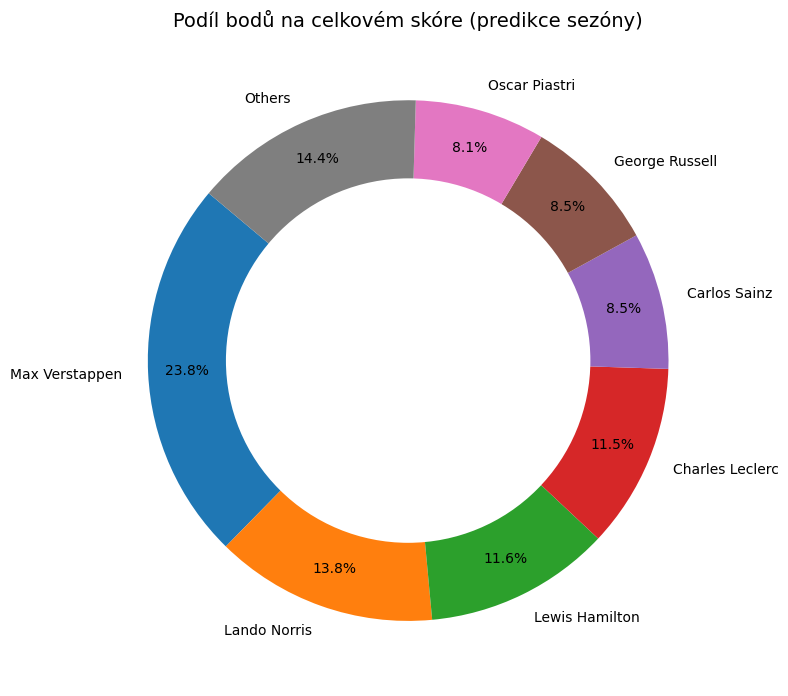

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Předpokládám, že máš už DataFrame `final_standings`
# (pokud ne, tak ho definujeme znovu podle předchozí tabulky)

# Spočítat celkový počet bodů
total_points = final_standings['Points'].sum()

# Vypočítat procenta
final_standings['Percentage'] = final_standings['Points'] / total_points * 100

# Vybereme Top 8 jezdců, ostatní sloučíme do 'Others'
top7 = final_standings.head(7)
others_points = final_standings['Points'][7:].sum()
others_row = pd.DataFrame({
    'Driver': ['Others'],
    'Team': ['Various'],
    'Points': [others_points],
    'Percentage': [others_points / total_points * 100]
}, index=[999])  # index aby se nepral s původními daty

# Spojíme Top8 + Others
final_plot = pd.concat([top7, others_row])

# Vytvořit donut graf
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    final_plot['Points'],
    labels=final_plot['Driver'],
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85
)

# Udělat \"donut\" přidáním bílé díry uprostřed
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Styly
plt.title('Podíl bodů na celkovém skóre (predikce sezóny)', fontsize=14)
plt.tight_layout()

# Uložit obrázek
plt.savefig('donut_chart_final_points.png', dpi=300)
plt.show()


In [38]:
# Ulozit do CSV
race_results_df.to_csv('predicted_top10_per_race.csv', index=False)
final_standings.to_csv('predicted_final_standings.csv', index=False)

print("\n📅 Vysledky ulozeny do 'predicted_top10_per_race.csv' a 'predicted_final_standings.csv'")


📅 Vysledky ulozeny do 'predicted_top10_per_race.csv' a 'predicted_final_standings.csv'


In [39]:
import pandas as pd

# ===  Načti reálné pořadí ===
real_standings = pd.read_csv("y_true_champ.csv", sep=';')

# ===  Zkontroluj, že jména jezdců jsou kompatibilní ===
real_standings['Driver'] = real_standings['Driver'].str.strip()
final_standings['Driver'] = final_standings['Driver'].str.strip()

# === Získání top-k z obou pořadí ===
def compute_hit_rate(predicted_df, real_df, k=5):
    pred_top_k = set(predicted_df['Driver'].head(k))
    real_top_k = set(real_df.sort_values(by='TruePoints', ascending=False)['Driver'].head(k))
    
    hits = pred_top_k & real_top_k
    hit_rate = len(hits) / k
    
    print(f"\n Top-{k} Hit Rate: {hit_rate:.2f}")
    print(f" Správně predikovaní jezdci v top-{k}: {hits}")
    return hit_rate

# Výpočet hit-rate pro top 5 a top 10
hit_rate_5 = compute_hit_rate(final_standings, real_standings, k=5)
hit_rate_10 = compute_hit_rate(final_standings, real_standings, k=10)



 Top-5 Hit Rate: 0.80
 Správně predikovaní jezdci v top-5: {'Carlos Sainz', 'Lando Norris', 'Charles Leclerc', 'Max Verstappen'}

 Top-10 Hit Rate: 0.80
 Správně predikovaní jezdci v top-10: {'Fernando Alonso', 'Lando Norris', 'George Russell', 'Charles Leclerc', 'Oscar Piastri', 'Max Verstappen', 'Lewis Hamilton', 'Carlos Sainz'}


In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Sloučíme obě tabulky ===
merged_df = pd.merge(
    final_standings, real_standings,
    on='Driver', how='inner'
)

merged_df.head()


Driver      Team  Points  Percentage  TrueTeam  TruePoints
0   Max Verstappen  Red Bull     576   23.762376  Red Bull         437
1     Lando Norris   McLaren     335   13.820132   McLaren         374
2   Lewis Hamilton  Mercedes     280   11.551155  Mercedes         223
3  Charles Leclerc   Ferrari     278   11.468647   Ferrari         356
4     Carlos Sainz   Ferrari     206    8.498350   Ferrari         290

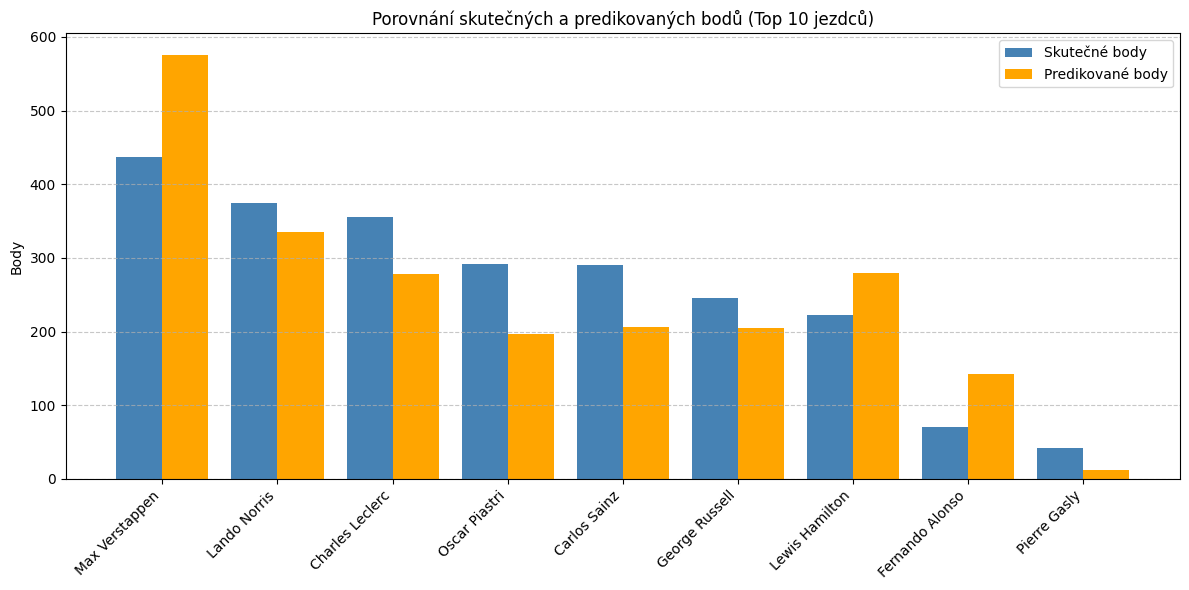

In [41]:
# Seřadíme podle skutečných bodů a vezmeme top 10
top10_df = merged_df.sort_values(by='TruePoints', ascending=False).head(10)


# ===  Vizualizace ===
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(top10_df))

# Sloupce pro skutečné a predikované body
plt.bar(
    [i - bar_width/2 for i in index],
    top10_df['TruePoints'],
    width=bar_width,
    label='Skutečné body',
    color='steelblue'
)

plt.bar(
    [i + bar_width/2 for i in index],
    top10_df['Points'],
    width=bar_width,
    label='Predikované body',
    color='orange'
)

# === 3. Vzhled a popisky ===
plt.xticks(index, top10_df['Driver'], rotation=45, ha='right')
plt.ylabel('Body')
plt.title('Porovnání skutečných a predikovaných bodů (Top 10 jezdců)')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('champ_result_pred_x_true.png', dpi=300)


plt.show()

In [42]:
top10_df.head()

Driver      Team  Points  Percentage  TrueTeam  TruePoints
0   Max Verstappen  Red Bull     576   23.762376  Red Bull         437
1     Lando Norris   McLaren     335   13.820132   McLaren         374
3  Charles Leclerc   Ferrari     278   11.468647   Ferrari         356
6    Oscar Piastri   McLaren     196    8.085809   McLaren         292
4     Carlos Sainz   Ferrari     206    8.498350   Ferrari         290